In [1]:
from scipy.io import arff
import time
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn import metrics as mt
import getpass
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV
import glob

import warnings
warnings.filterwarnings('ignore')

In [2]:
# C:\Users\KeyboardWarrior\Desktop\Conda

path = r'C:\Users\sherm\Documents\Grad School - Classes\MSDS - 7333 - Quantifying the World\Case Study 4\data'
files = [i for i in os.listdir(path)]

df_concat = pd.DataFrame()

for i in files:
    df, meta = arff.loadarff(path + '/' + i)
    df = pd.DataFrame(df)
    df_concat = df_concat.append(df, ignore_index=True)


In [3]:
df_concat

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'


In [4]:
df_concat.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,1.088350e+03,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,4.993325e+03,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000


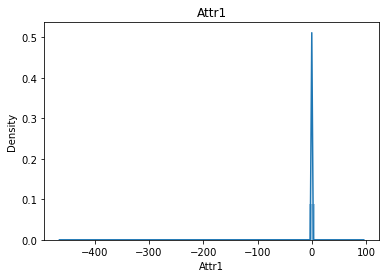

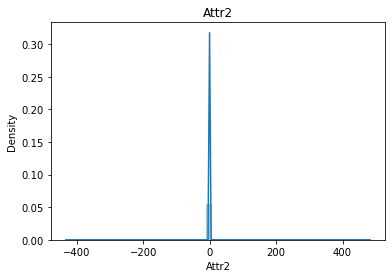

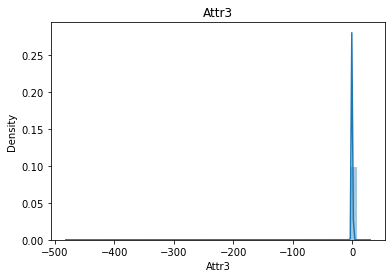

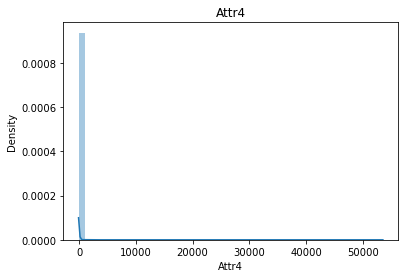

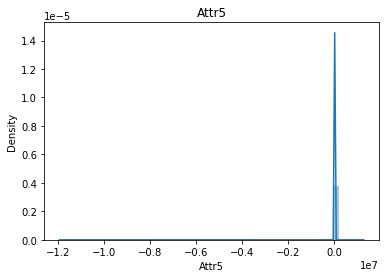

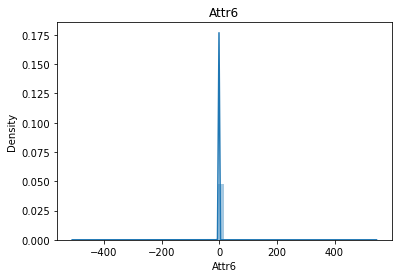

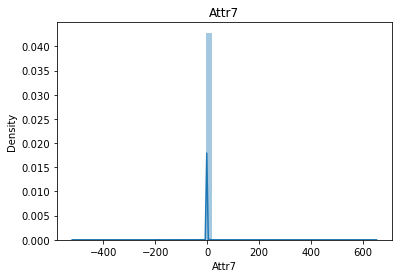

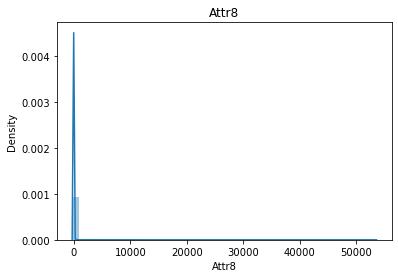

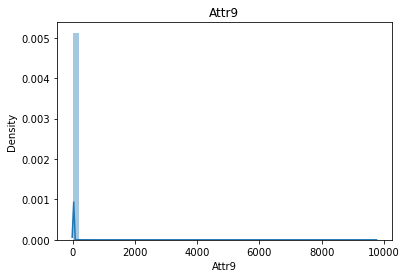

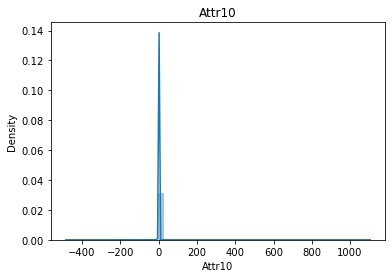

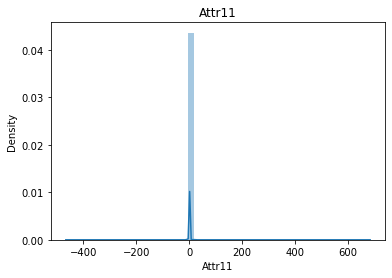

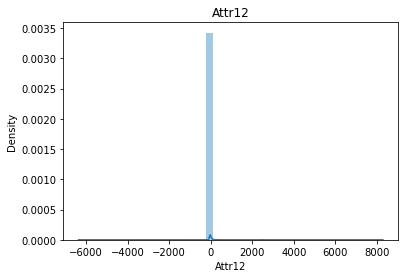

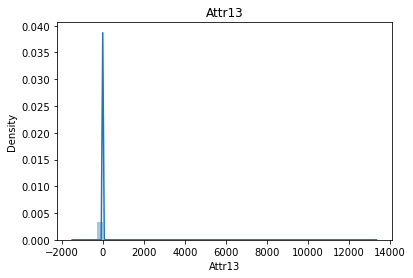

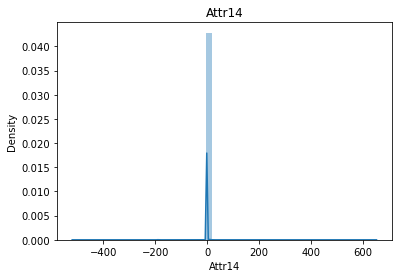

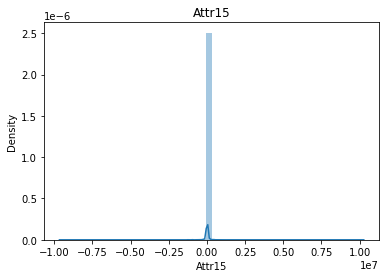

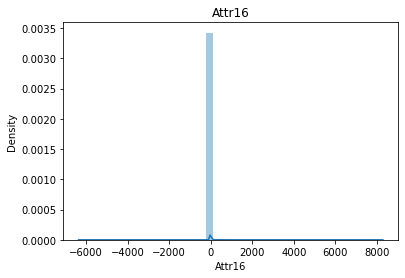

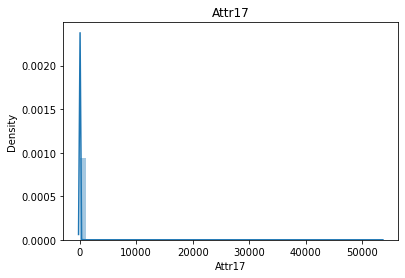

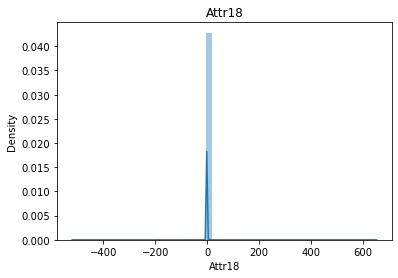

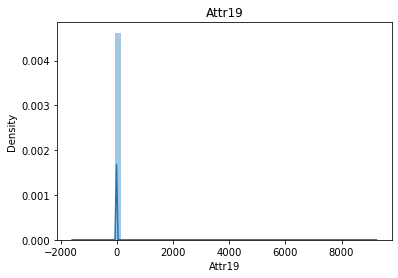

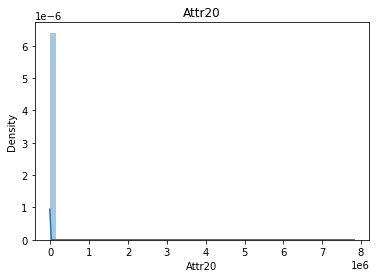

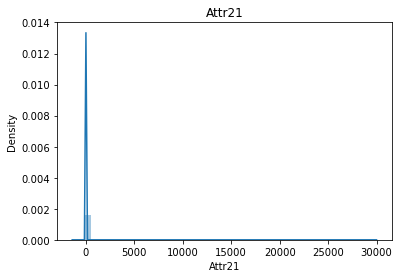

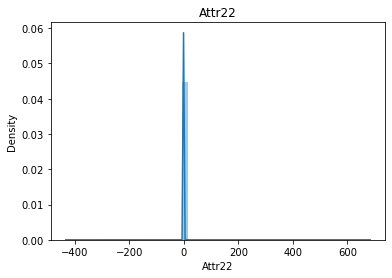

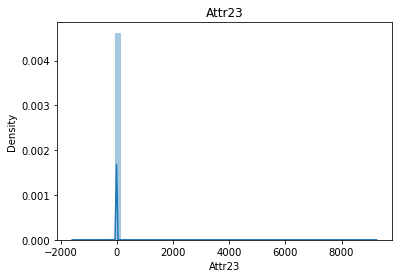

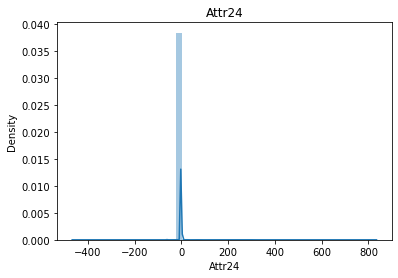

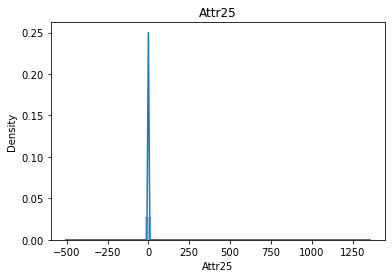

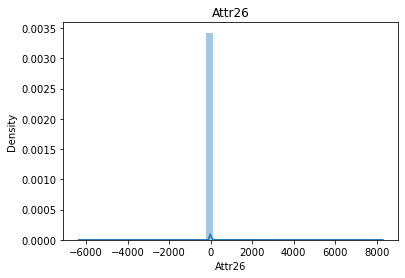

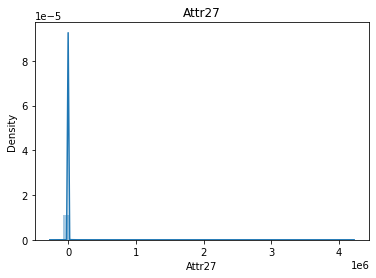

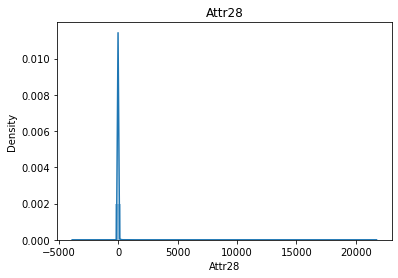

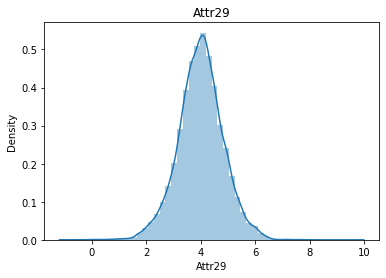

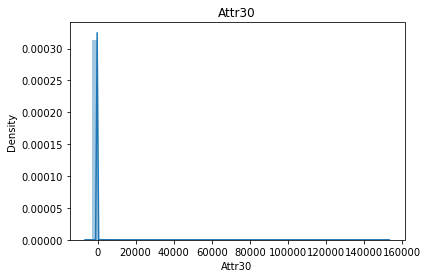

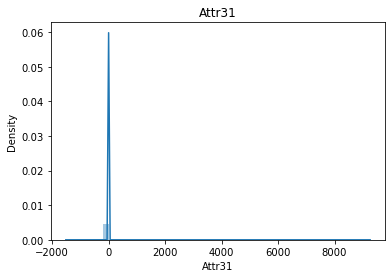

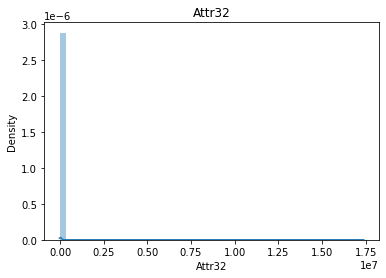

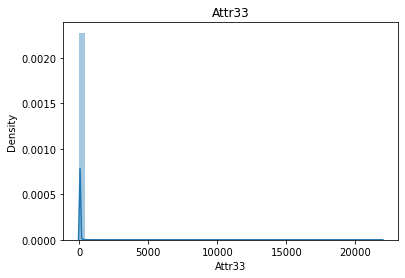

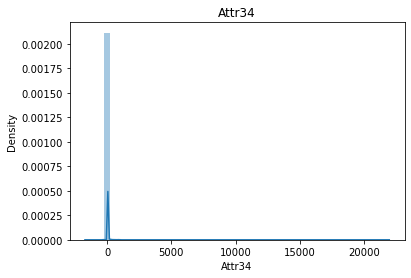

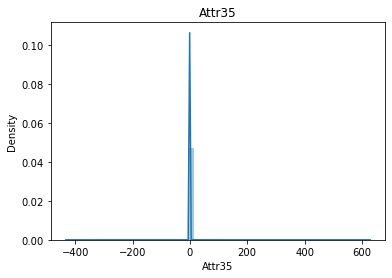

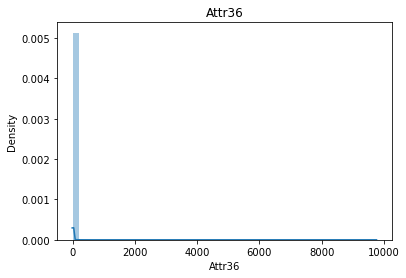

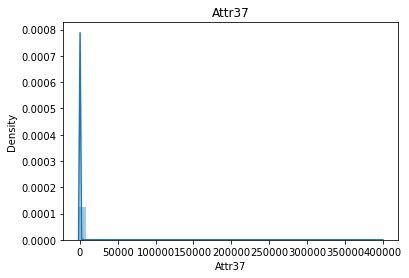

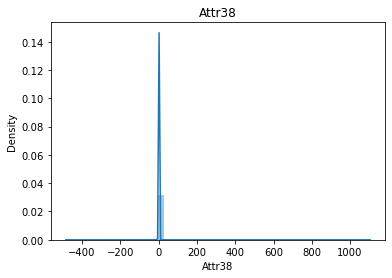

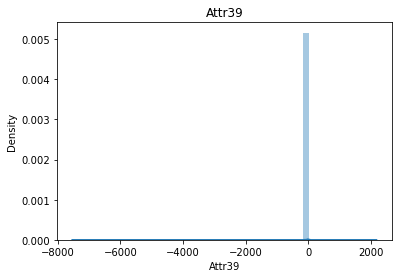

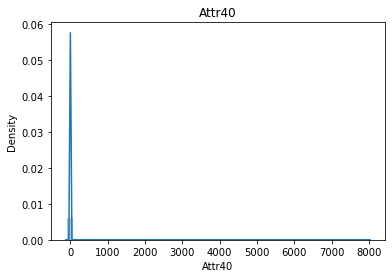

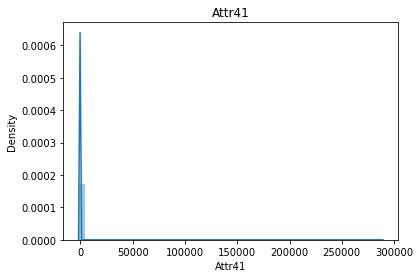

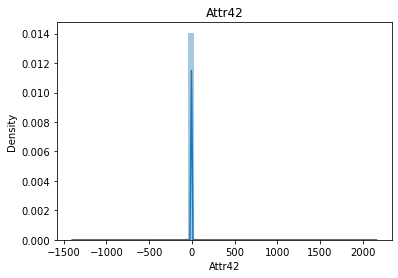

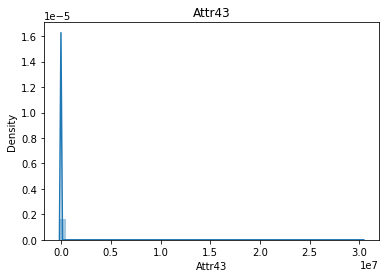

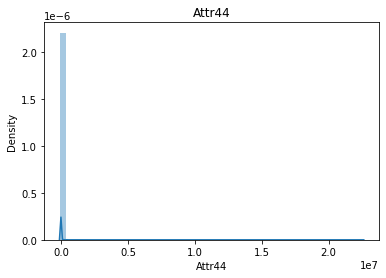

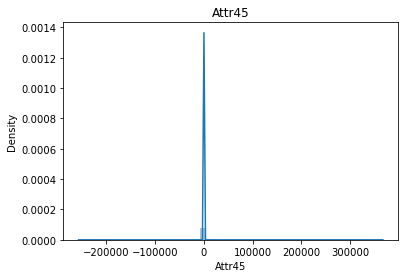

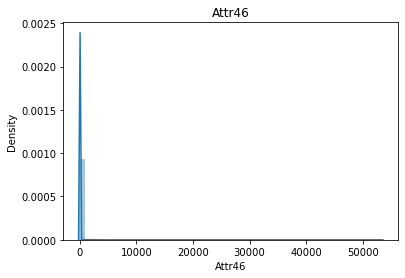

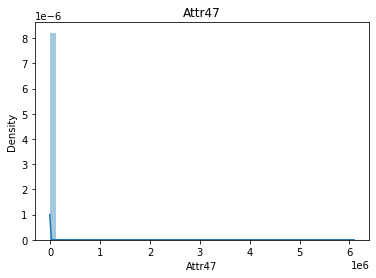

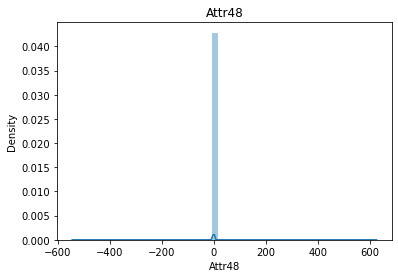

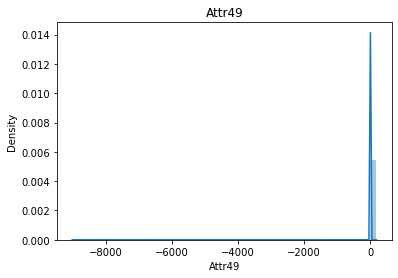

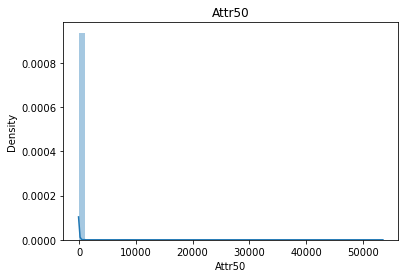

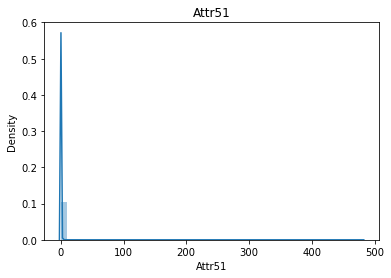

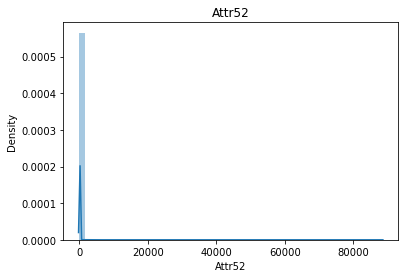

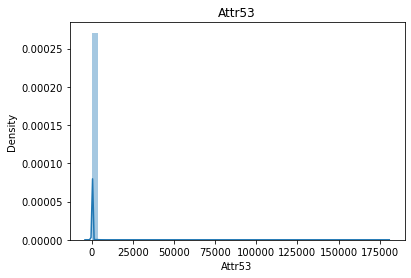

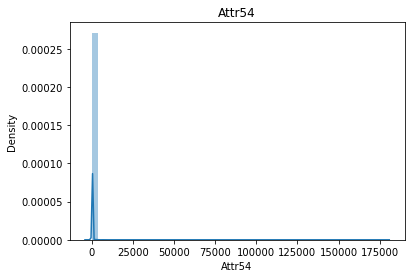

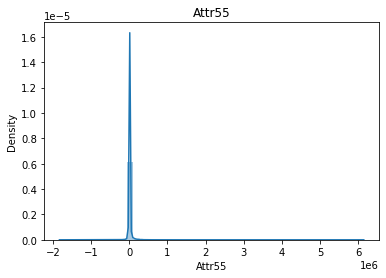

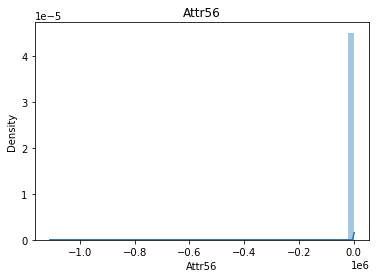

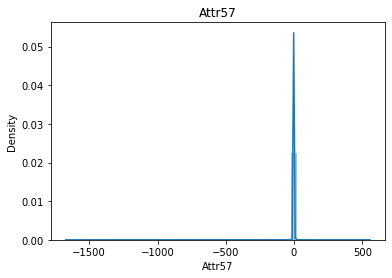

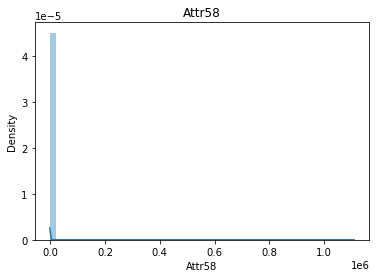

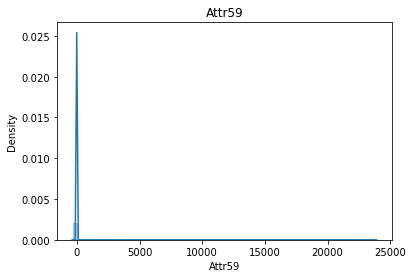

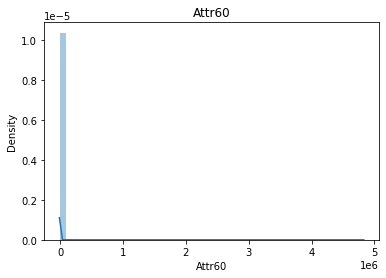

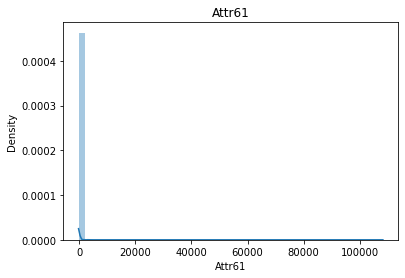

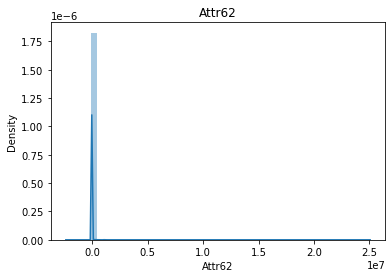

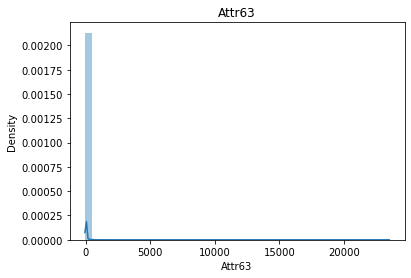

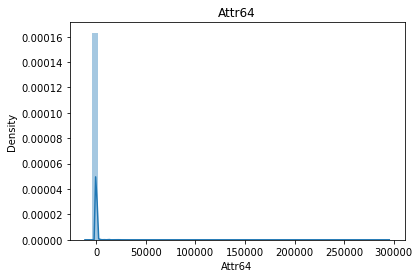

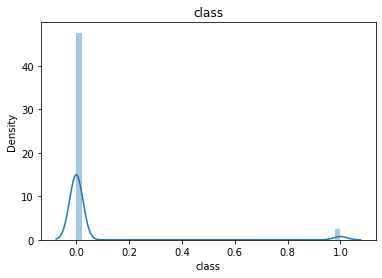

In [5]:
warnings.filterwarnings('ignore')

for i in df_concat.columns:
    sns.distplot(df_concat.loc[:,i]).set(title=i)
    plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   5907 non-null   float64
 1   Attr2   5907 non-null   float64
 2   Attr3   5907 non-null   float64
 3   Attr4   5889 non-null   float64
 4   Attr5   5899 non-null   float64
 5   Attr6   5907 non-null   float64
 6   Attr7   5907 non-null   float64
 7   Attr8   5892 non-null   float64
 8   Attr9   5909 non-null   float64
 9   Attr10  5907 non-null   float64
 10  Attr11  5907 non-null   float64
 11  Attr12  5889 non-null   float64
 12  Attr13  5910 non-null   float64
 13  Attr14  5907 non-null   float64
 14  Attr15  5904 non-null   float64
 15  Attr16  5892 non-null   float64
 16  Attr17  5892 non-null   float64
 17  Attr18  5907 non-null   float64
 18  Attr19  5910 non-null   float64
 19  Attr20  5910 non-null   float64
 20  Attr21  5807 non-null   float64
 21  Attr22  5907 non-null   float64
 22  

In [7]:
df_concat.isnull().values.any()

True

In [8]:
df_concat.isnull().any()

Attr1      True
Attr2      True
Attr3      True
Attr4      True
Attr5      True
          ...  
Attr61     True
Attr62     True
Attr63     True
Attr64     True
class     False
Length: 65, dtype: bool

In [9]:
colname = list(df_concat.columns)
rank = {}

for i in range(len(colname)):
    count = df_concat[df_concat.columns[i]].isna().sum()
    rank[i] = count
    print("Column '{col}' has {ct} NAs".format(col = colname[i], ct = count))

Column 'Attr1' has 8 NAs
Column 'Attr2' has 8 NAs
Column 'Attr3' has 8 NAs
Column 'Attr4' has 134 NAs
Column 'Attr5' has 89 NAs
Column 'Attr6' has 8 NAs
Column 'Attr7' has 8 NAs
Column 'Attr8' has 94 NAs
Column 'Attr9' has 9 NAs
Column 'Attr10' has 8 NAs
Column 'Attr11' has 44 NAs
Column 'Attr12' has 134 NAs
Column 'Attr13' has 127 NAs
Column 'Attr14' has 8 NAs
Column 'Attr15' has 36 NAs
Column 'Attr16' has 95 NAs
Column 'Attr17' has 94 NAs
Column 'Attr18' has 8 NAs
Column 'Attr19' has 128 NAs
Column 'Attr20' has 127 NAs
Column 'Attr21' has 5854 NAs
Column 'Attr22' has 8 NAs
Column 'Attr23' has 127 NAs
Column 'Attr24' has 922 NAs
Column 'Attr25' has 8 NAs
Column 'Attr26' has 95 NAs
Column 'Attr27' has 2764 NAs
Column 'Attr28' has 812 NAs
Column 'Attr29' has 8 NAs
Column 'Attr30' has 127 NAs
Column 'Attr31' has 127 NAs
Column 'Attr32' has 368 NAs
Column 'Attr33' has 134 NAs
Column 'Attr34' has 94 NAs
Column 'Attr35' has 8 NAs
Column 'Attr36' has 8 NAs
Column 'Attr37' has 18984 NAs
Colum

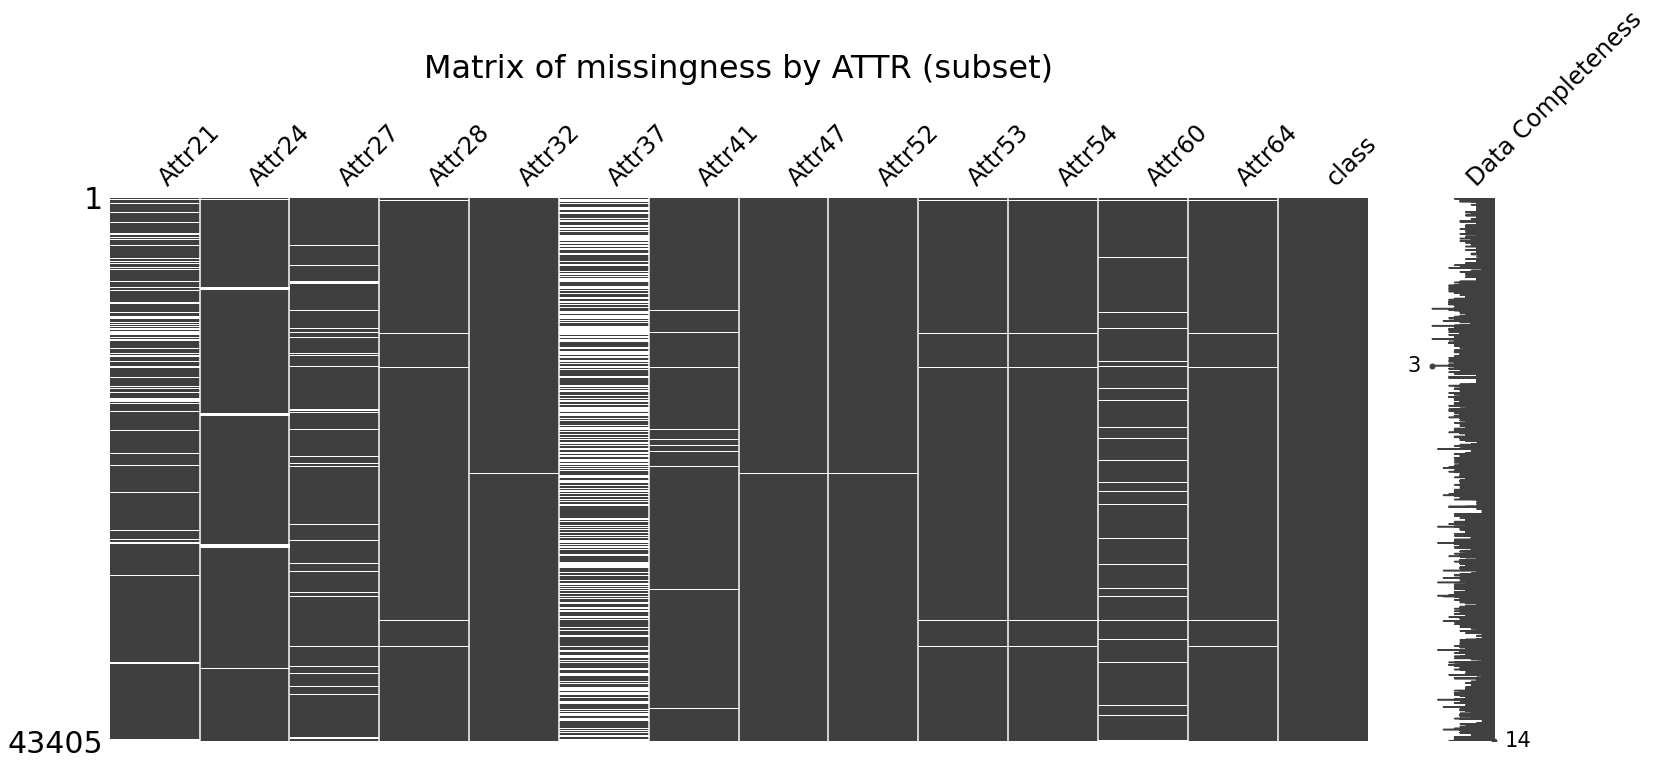

In [10]:
import missingno as msno

list_most_missing_plus_class = ['Attr21','Attr24','Attr27','Attr28','Attr32','Attr37','Attr41','Attr47','Attr52',
                                'Attr53','Attr54','Attr60','Attr64','class']

msno.matrix(df_concat[list_most_missing_plus_class], labels=True, fontsize=24)
plt.title('Matrix of missingness by ATTR (subset)\n', fontsize=32)
plt.show()

In [11]:
# dict(sorted(rank.items(), key=lambda item: item[1]))

column_rank = pd.DataFrame(rank.items(), columns = ['Attr', 'Missing Count'])
column_rank["Missing Percentage"] = round(column_rank["Missing Count"]/len(df_concat)*100,2)
column_rank.sort_values("Missing Count", ascending=False)

,Attr,Missing Count,Missing Percentage
36,36,18984,43.74
20,20,5854,13.49
26,26,2764,6.37
59,59,2152,4.96
44,44,2147,4.95
...,...,...,...
9,9,8,0.02
56,56,7,0.02
58,58,7,0.02
54,54,1,0.00


In [12]:
filledDF = df_concat.apply(lambda x: x.fillna(x.median()), axis = 0)
filledDF

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'


In [13]:
cleanedDF = filledDF.drop(columns='Attr37')

In [14]:
print(cleanedDF['class'])
print(cleanedDF['class'].unique())
class_labels = cleanedDF['class'].unique()

0        b'0'
1        b'0'
2        b'0'
3        b'0'
4        b'0'
         ... 
43400    b'1'
43401    b'1'
43402    b'1'
43403    b'1'
43404    b'1'
Name: class, Length: 43405, dtype: object
[b'0' b'1']


In [111]:
cleanedDF['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

In [112]:
2091/41314

0.05061238321150215

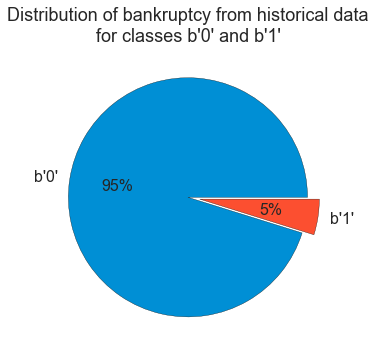

In [15]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.pie(cleanedDF['class'].value_counts(),
       labels=['b\'0\'','b\'1\''],
       colors=['#008fd5', '#fc4f30'],
       wedgeprops={'edgecolor': 'black'},
       autopct='%1.f%%',
       explode = (0, 0.1),
       textprops={'fontsize': 16})
ax.set_title('Distribution of bankruptcy from historical data\nfor classes b\'0\' and b\'1\'', fontsize=18)

plt.show()

In [16]:
cleanedDF['class'] = cleanedDF['class'].astype('str')

i = 0
for line in cleanedDF['class']:
    cleanedDF['class'][i] = line.split('\'')[1]
    i += 1

cleanedDF

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,0
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,0
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,0
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,0
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,1
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,1
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,1
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,1


Starting Prediction Algorithms

In [17]:
scaler = StandardScaler()

x_data = cleanedDF.drop(columns='class')
x_scaled = scaler.fit_transform(x_data)
y_data = cleanedDF['class']

In [18]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2 , stratify=y_data, random_state=63)
x_s_train, x_s_test, y_train, y_test = train_test_split(x_scaled, y_data, test_size=0.2 , stratify=y_data, random_state=63)

<AxesSubplot:xlabel='class', ylabel='Density'>

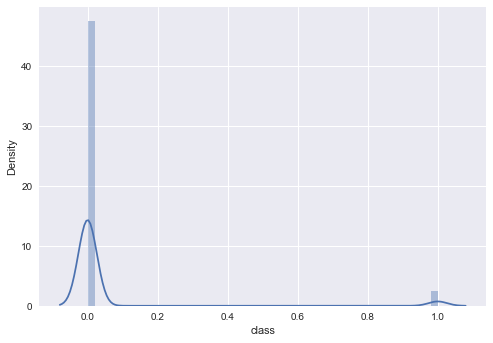

In [19]:
sns.distplot(y_train)

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

shuffler = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=47)

XGBoost

In [28]:
y_train_vals = pd.to_numeric(y_train)
y_test_vals = pd.to_numeric(y_test)

In [29]:
# state_list = [1,5,10,24,48]

# dxTrain = xgb.DMatrix(x_train)
# dxTest = xgb.DMatrix(x_test)
dTrain_scaled = xgb.DMatrix(x_s_train, label=y_train_vals)
dTest_scaled = xgb.DMatrix(x_s_test, label=y_test_vals)

In [22]:
# xg_params = {'booster':['gbtree'],
#              'eta': [0.01,0.07,0.15,0.3,0.5,1],
#              'max_depth':[1,2,3,4,6],
#              'objective': ['multi:softprob'],
#              'min_child_weight':[1,2,3,4,6],
#              'max_delta_step':[1,2,4,6,10,15,20],
#              'subsample': [0.95],
#              'num_class': [2],
#              'scale_pos_weight':[0.04,0.06,0.08,0.1,0.46,0.48,0.50,0.52,0.54,0.9,0.92,0.94,0.96],
#              'n_estimators':[1000]}

In [23]:
xgb_clf = xgb.XGBClassifier()

In [24]:
# from sklearn.model_selection import RandomizedSearchCV
score_m = ['roc_auc']

# grid_xgb = RandomizedSearchCV(xgb_clf, param_distributions=xg_params,
#                               n_iter=120, cv=shuffler, scoring='roc_auc',
#                               n_jobs=10)

# xgb_fit = grid_xgb.fit(x_s_train, y_train)

In [42]:
from xgboost import DMatrix
params = {'eta':0.3,
          'max_depth':3,
          'objective':'multi:softprob',
          'min_child_weight':2,
          'max_delta_step':1,
          'subsample':0.90,
          'num_class':2,
          'eval_metric':'auc'}

from sklearn.model_selection import KFold
folder = KFold(n_splits=5, shuffle=True, random_state=47)

xgb.cv(params, dTrain_scaled, num_boost_round=1000, folds=folder, early_stopping_rounds=10)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.775907,0.011494,0.769267,0.018012
1,0.815764,0.014627,0.804663,0.022177
2,0.831869,0.008506,0.822167,0.017355
3,0.838250,0.010841,0.827264,0.018281
4,0.855912,0.012710,0.845522,0.018306
...,...,...,...,...
169,0.996270,0.000367,0.957128,0.005671
170,0.996343,0.000366,0.957152,0.005600
171,0.996421,0.000351,0.957181,0.005518
172,0.996467,0.000367,0.957128,0.005500


In [43]:
# xgb_model = xgb_fit.best_estimator_
# print(xgb_model)
# print(xgb_fit.best_params_)
# print(xgb_fit.cv_results_)

xgb_model = xgb.XGBClassifier(**params)

In [44]:
xgb_model.fit(x_s_train, y_train, eval_metric='auc')
xgb_preds = xgb_model.predict(x_s_test)
xgb_pred_probs = xgb_model.predict_proba(x_s_test)

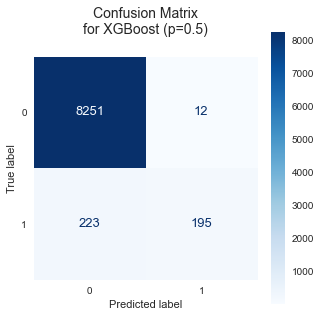

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, xgb_preds)

font = {'size'   : 13}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
plt.title('Confusion Matrix\nfor XGBoost (p=0.5)\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

In [45]:
threshold_list = np.arange(0.01,0.99,0.01)
threshold_list

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98])

In [47]:
from sklearn.metrics import f1_score

labels = y_test.unique()
f1_dict = {}

for t in threshold_list:
    new_preds = (xgb_pred_probs [:,1] >= t).astype('int')
    f1_dict.update({t: f1_score(y_test_vals, new_preds)})
    
sorted(f1_dict.items(), key=lambda x: x[1], reverse=True)[0:10]

[(0.3, 0.6921985815602837),
 (0.31, 0.6904422253922968),
 (0.29000000000000004, 0.6882022471910113),
 (0.26, 0.6857142857142857),
 (0.28, 0.6852367688022284),
 (0.27, 0.6850828729281768),
 (0.25, 0.6828609986504723),
 (0.32, 0.6801152737752162),
 (0.24000000000000002, 0.678237650200267),
 (0.35000000000000003, 0.6754772393538914)]

In [69]:
threshold = 1 - 0.21
predicted_xgb = (xgb_pred_probs [:,0] <= threshold).astype('int')
predicted_xgb = [str(i) for i in predicted_xgb]

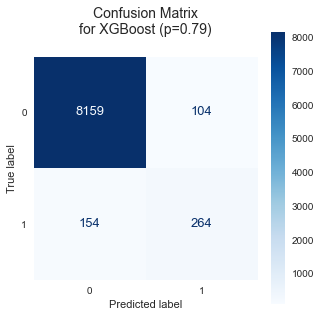

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, predicted_xgb)

font = {'size'   : 13}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
plt.title('Confusion Matrix\nfor XGBoost (p=0.79)\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

RandomForest Classifier

In [72]:
rf_params = {'criterion':['gini'],
             'max_depth':range(2,11,2),
             'max_features':['sqrt','log2'],
             'min_impurity_decrease':np.logspace(-10,2,13),
             'class_weight':[None,'balanced','balanced_subsample'],
             'n_jobs':[10]}

In [73]:
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf

RandomForestClassifier(n_estimators=500)

In [74]:
rf_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [75]:
%%time

grid_rf = RandomizedSearchCV(rf_clf, rf_params, n_iter=40, cv=shuffler, scoring=score_m, refit='roc_auc')
rf_fit = grid_rf.fit(x_s_train, y_train)
# out_rf = cross_val_predict(rf_clf)

Wall time: 16min 40s


In [76]:
grid_rf

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=47, test_size=0.2,
            train_size=None),
                   estimator=RandomForestClassifier(n_estimators=500),
                   n_iter=40,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini'],
                                        'max_depth': range(2, 11, 2),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_impurity_decrease': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'n_jobs': [10]},
                   refit='roc_auc', scoring=['roc_auc'])

In [77]:
rf_model = rf_fit.best_estimator_
print(rf_model)
print(rf_fit.best_params_)
print(rf_fit.cv_results_)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       max_features='sqrt', min_impurity_decrease=0.0001,
                       n_estimators=500, n_jobs=10)
{'n_jobs': 10, 'min_impurity_decrease': 0.0001, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini', 'class_weight': 'balanced'}
{'mean_fit_time': array([7.82440715, 2.67317772, 2.55297656, 4.3318985 , 2.28466225,
       9.79333873, 5.1689858 , 2.30865512, 1.86939287, 5.76204991,
       1.96826162, 1.93036876, 8.46600699, 3.86603947, 8.37552099,
       3.32942991, 5.87669201, 2.08047876, 3.20329833, 7.86939373,
       6.28394427, 2.03604002, 2.58157411, 1.61222391, 7.54759178,
       5.84914799, 2.50375128, 5.63146367, 9.45518889, 4.3885942 ,
       6.01097312, 2.48310962, 9.70080671, 2.1231122 , 3.10801425,
       3.12603197, 7.49392238, 8.17907591, 1.67479091, 2.53816423]), 'std_fit_time': array([0.92740426, 0.05849144, 0.04438724, 0.17478126, 0.05757805,
       0.40859154, 0.20670194, 0.0987

In [78]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, x_s_train, y_train, cv=shuffler, scoring='roc_auc')
scores

array([0.8860406 , 0.88383092, 0.88740533, 0.87790954, 0.88346106])

In [79]:
rf_model.fit(x_s_train, y_train)
preds = rf_model.predict(x_s_test)
pred_probs = rf_model.predict_proba(x_s_test)

In [80]:
count = 0
for i in pred_probs:
    if i[0] > 0.90:
        count += 1

print(count, 'out of', len(pred_probs))

1212 out of 8681


In [81]:
y_test_vals = pd.to_numeric(y_test)

In [82]:
from sklearn.metrics import f1_score

labels = y_test.unique()
f1_dict = {}

for t in threshold_list:
    new_preds = (pred_probs [:,1] >= t).astype('int')
    f1_dict.update({t: f1_score(y_test_vals, new_preds)})

In [83]:
sorted(f1_dict.items(), key=lambda x: x[1], reverse=True)[0:10]

[(0.62, 0.4197802197802198),
 (0.61, 0.4162219850586979),
 (0.6, 0.4161616161616161),
 (0.63, 0.4155251141552511),
 (0.59, 0.41392649903288203),
 (0.5800000000000001, 0.4117647058823529),
 (0.5700000000000001, 0.4094076655052265),
 (0.64, 0.40710059171597635),
 (0.56, 0.4003308519437552),
 (0.55, 0.3990610328638498)]

In [84]:
threshold = 0.52
predicted = (pred_probs [:,0] <= threshold).astype('int')
predicted = [str(i) for i in predicted]

In [85]:
len(predicted)

8681

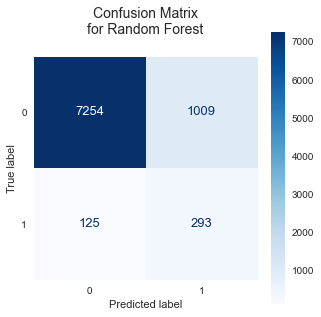

In [107]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, predicted)

font = {'size': 13}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
plt.title('Confusion Matrix\nfor Random Forest\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

Logistic Regression Classification

In [87]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(penalty='l2')

lr_params = {'C': np.logspace(-10,10,100),
             'solver': ['newton-cf','lbfgs','sag'],
             'max_iter': range(50,200,20)}

In [88]:
grid_lr = RandomizedSearchCV(lr_clf, lr_params, n_iter=60, cv=shuffler, scoring=score_m, refit='roc_auc')
lr_fit = grid_lr.fit(x_s_train, y_train)

In [89]:
lr_model = lr_fit.best_estimator_
print(lr_model)
print(lr_fit.best_params_)
print(lr_fit.cv_results_)

LogisticRegression(C=3430.469286314912, max_iter=150)
{'solver': 'lbfgs', 'max_iter': 150, 'C': 3430.469286314912}
{'mean_fit_time': array([1.57906227, 0.00797181, 0.23106494, 2.77821746, 1.87524424,
       2.51220226, 3.29429936, 0.01275892, 0.00957465, 0.93731642,
       0.00917625, 0.95226121, 1.65678105, 3.39600592, 0.37620516,
       1.29135556, 1.69689875, 0.01097088, 0.98827472, 0.008178  ,
       0.00858369, 0.00877929, 0.57805543, 0.08935537, 0.01017308,
       0.42926016, 2.799441  , 0.00738149, 0.07759271, 2.11690369,
       2.95549884, 1.67534795, 0.33111596, 1.9495172 , 0.009375  ,
       1.44992418, 0.00757971, 0.08597064, 2.74398384, 0.87967434,
       0.17952199, 0.27546525, 0.00837884, 0.00917592, 2.47321806,
       0.0091754 , 0.00857792, 0.00877862, 0.0091754 , 0.45528541,
       0.0861702 , 0.08098416, 3.09444604, 0.00738015, 0.00777912,
       0.00937572, 0.00877695, 0.00857701, 1.48046465, 0.00758047]), 'std_fit_time': array([8.44672619e-02, 1.12894659e-05, 9.8122

In [101]:
lr_model = lr_model.set_params(**lr_fit.best_params_)
lr_model.fit(x_s_train, y_train)
lr_preds = lr_model.predict(x_s_test)
lr_pred_probs = lr_model.predict_proba(x_s_test)
lr_model.get_params()

{'C': 3430.469286314912,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 150,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [91]:
f1_dict = {}

for t in threshold_list:
    new_preds = (lr_pred_probs[:,1] >= t).astype('int')
    f1_dict.update({t: f1_score(y_test_vals, new_preds)})
    
sorted(f1_dict.items(), key=lambda x: x[1], reverse=True)[0:10]

[(0.62, 0.4197802197802198),
 (0.61, 0.4162219850586979),
 (0.6, 0.4161616161616161),
 (0.63, 0.4155251141552511),
 (0.59, 0.41392649903288203),
 (0.5800000000000001, 0.4117647058823529),
 (0.5700000000000001, 0.4094076655052265),
 (0.64, 0.40710059171597635),
 (0.56, 0.4003308519437552),
 (0.55, 0.3990610328638498)]

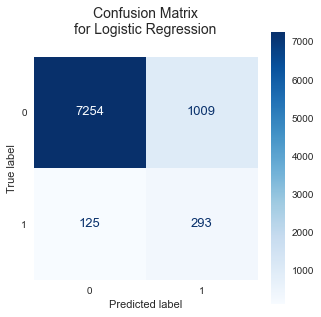

In [116]:
threshold = 0.62
lr_predicted = (lr_pred_probs [:,0] <= threshold).astype('int')
lr_predicted = [str(i) for i in predicted]


cm = confusion_matrix(y_test, lr_predicted)

font = {'size': 13}
plt.rc('font', **font)

c_disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
plt.title('Confusion Matrix\nfor Logistic Regression\n', fontsize=14)
c_disp.plot(cmap=plt.cm.Blues, ax=ax)

In [100]:
lr_pred_probs

array([[0.73779258, 0.26220742],
       [0.76589258, 0.23410742],
       [0.88612509, 0.11387491],
       ...,
       [0.74065437, 0.25934563],
       [0.77488198, 0.22511802],
       [0.53866137, 0.46133863]])

Graphing Composite Scores

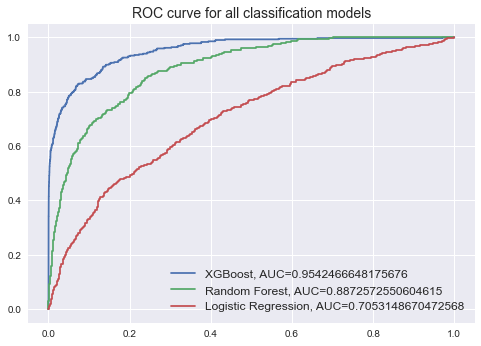

In [122]:
from sklearn.metrics import roc_curve, roc_auc_score
# XGBoost
fpr, tpr, _ = roc_curve(y_test.ravel(),  xgb_pred_probs[:,1], pos_label='1')
auc = roc_auc_score(y_test, xgb_pred_probs[:,1], labels=labels)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))
plt.legend(loc=4)

# Random Forest
fpr, tpr, _ = roc_curve(y_test.ravel(),  pred_probs[:,1], pos_label='1')
auc = roc_auc_score(y_test, pred_probs[:,1], labels=labels)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))
plt.legend(loc=4)

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test.ravel(),  lr_pred_probs[:,1], pos_label='1')
auc = roc_auc_score(y_test, lr_pred_probs[:,1], labels=labels)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.legend(loc=4, fontsize=12)

# Plot All
plt.title('ROC curve for all classification models', fontsize=14)
plt.show()

In [109]:
from sklearn.metrics import classification_report

print("\tXGBOOST Classification Report\n------------------------------------------------------")
print(classification_report(y_test.tolist(), xgb_preds))
print("\tRandom Forest Classification Report\n------------------------------------------------------")
print(classification_report(y_test.tolist(), predicted))
print("\tLogistic Regression Classification Report\n------------------------------------------------------")
print(classification_report(y_test.tolist(), lr_preds))

	XGBOOST Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8263
           1       0.94      0.47      0.62       418

    accuracy                           0.97      8681
   macro avg       0.96      0.73      0.80      8681
weighted avg       0.97      0.97      0.97      8681

	Random Forest Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8263
           1       0.23      0.70      0.34       418

    accuracy                           0.87      8681
   macro avg       0.60      0.79      0.63      8681
weighted avg       0.95      0.87      0.90      8681

	Logistic Regression Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0   